In [ ]:
!pip install timm
!pip install lightning
!pip install astropy
import torch
import torch.nn as nn
import timm
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm


import sys
sys.path.append('/content/')

from dataloader_fits import SunImageDataset

from lightning.fabric import Fabric

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

import scipy.stats as stats

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

zip_path = '/content/drive/MyDrive/Dataset/aia_synoptic_copy_1.zip'
extract_path = '/content/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
# Hyper-parameters
input_size = 224*224
hidden_size = 166
# hidden_size = 1024
num_epochs = 10
batch_size = 2
learning_rate = 0.001
dropout = 0.5
lstm_layers = 2

k_folds = 5

In [ ]:
import random
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

set_seed(42)

In [ ]:
dataset = SunImageDataset(csv_file="/content/dataset_collab_full.csv", offset=0)

total_size = len(dataset)
fold_size = total_size // k_folds
indices = list(range(total_size))

k_fold_1_indices = indices[:fold_size]
k_fold_2_indices = indices[fold_size:2*fold_size]
k_fold_3_indices = indices[2*fold_size:3*fold_size]
k_fold_4_indices = indices[3*fold_size:4*fold_size]
k_fold_5_indices = indices[4*fold_size:]

print(len(k_fold_1_indices))
print(len(k_fold_2_indices))
print(len(k_fold_3_indices))
print(len(k_fold_4_indices))
print(len(k_fold_5_indices))

dataloaders = [k_fold_1_indices, k_fold_2_indices, k_fold_3_indices, k_fold_4_indices, k_fold_5_indices]

# Get date list
kp_dates = pd.read_csv("/content/matched_kp_dates_collab_full.csv")
kp_dates_list = kp_dates["date"].tolist()

1097
1097
1097
1097
1099


In [ ]:
# Get active indices
dataset_csv_file = pd.read_csv("/content/dataset_collab_full.csv")
active_indices = []

for i in dataset_csv_file.index:
    if dataset_csv_file['Kp'][i] >= 3.667:
        active_indices.append(i)

active_dataloaders = []
for dataloader in dataloaders:
    active_dataloaders.append(list(set(dataloader) & set(active_indices)))

for dataloader in active_dataloaders:
    print(len(dataloader))

264
261
403
446
329


In [ ]:

class GmiSwinTransformer(nn.Module):
    def __init__(self, hidden_size: int):
        super(GmiSwinTransformer, self).__init__()

        # Batch normalization for 3 channels
        self.bn = nn.BatchNorm2d(3)

        # Initialize Swin Transformer
        self.pretrained_model = timm.create_model(
            'swin_base_patch4_window7_224',
            pretrained=True,
            num_classes=hidden_size
        )


        self.lstm = nn.LSTM(hidden_size, hidden_size * 2, lstm_layers, batch_first=True)

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.LeakyReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden_size*2, hidden_size),
            nn.Dropout(p=dropout),  # Added dropout probability
            nn.LeakyReLU(),
            nn.Linear(hidden_size, 1),
            # nn.LeakyReLU()

        )

    def forward(self, images) -> torch.Tensor:
        """
        Batch should be in format:
        {
            'images': torch.FloatTensor((10, 1, 224, 224))
        }
        """

        batch_size = images.shape[0]

        images = images.reshape(-1, 1, 224, 224)
        images = torch.cat([images, images, images], dim=1)
        normalized_images = self.bn(images)
        features = self.pretrained_model(normalized_images)
        image_features = features.view(batch_size, 10, -1)

        # hidden_states = torch.zeros(lstm_layers, image_features.size(0), hidden_size * 2)
        # cell_states = torch.zeros(lstm_layers, image_features.size(0), hidden_size * 2)
        # image_features, _ = self.lstm(image_features, (hidden_states, cell_states))
        image_features, _ = self.lstm(image_features)

        image_features = image_features[:, -1, :]
        output = self.fc(image_features)
        return output

# Initialize model
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = GmiSwinTransformer(hidden_size=hidden_size).to(device)
model = GmiSwinTransformer(hidden_size=hidden_size)

# print(torchsummary.summary(model, (10, 1, 224, 224)))

# Loss and optimizer
criterion = nn.MSELoss()

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

In [ ]:
torch.cuda.empty_cache()

In [ ]:
def calculate_rates(all_outputs, all_labels):
    storm_labels = []
    for output in all_labels:
        if output < 3.667:
            storm_labels.append(0)
        else:
            storm_labels.append(1)
    storm_outputs = []
    for output in all_outputs:
        if output < 3.667:
            storm_outputs.append(0)
        else:
            storm_outputs.append(1)

    # Calculate true positive, true negative, false positive, false negative
    tp = 0
    tn = 0
    fp = 0
    fn = 0

    for i in range(len(storm_labels)):
        if storm_labels[i] == 1 and storm_outputs[i] == 1:
            tp += 1
        elif storm_labels[i] == 0 and storm_outputs[i] == 0:
            tn += 1
        elif storm_labels[i] == 0 and storm_outputs[i] == 1:
            fp += 1
        elif storm_labels[i] == 1 and storm_outputs[i] == 0:
            fn += 1

    return tp, tn, fp, fn


def true_skill_score(tp, tn, fp, fn):

    # Calculate true skill score
    tss = (tp / (tp + fp)) - (fp / (fp + tn)) if ((tp > 0 and tn > 0) or fp > 0) else 0
    return tss

def calculate_metrics(tp, tn, fp, fn):
    # Calculate accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

    # Calculate precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0

    # Calculate recall
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    # Calculate F1 score
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return accuracy, precision, recall, f1





In [ ]:
def train_model(fabric):
  print(fabric.device)
  total_avg_test_loss = 0
  total_rmse = 0
  total_mse = 0
  total_mae = 0
  total_r2 = 0
  total_r = 0
  total_tts = 0
  total_accuracy = 0
  total_precision = 0
  total_recall = 0
  total_f1 = 0

  active_total_avg_test_loss = 0
  active_total_rmse = 0
  active_total_mse = 0
  active_total_mae = 0
  active_total_r2 = 0
  active_total_r = 0


  for i in range(k_folds):
      print(f'FOLD {i + 1}')
      print('--------------------------------')
      test_indices = dataloaders[i]
      active_test_indices = active_dataloaders[i]
      train_indices = []
      for j in range(k_folds):
          if j != i:
              train_indices += dataloaders[j]

      trainloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, train_indices), batch_size=batch_size, shuffle=True, num_workers=20, prefetch_factor=6, pin_memory=True, worker_init_fn=lambda _: np.random.seed(42))
      testloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, test_indices), batch_size=batch_size, shuffle=False, num_workers=20, prefetch_factor=6, pin_memory=True)
      active_testloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, active_test_indices), batch_size=batch_size, shuffle=False, num_workers=20, prefetch_factor=6, pin_memory=True)
      trainloader = fabric.setup_dataloaders(trainloader)
      testloader = fabric.setup_dataloaders(testloader)
      active_testloader = fabric.setup_dataloaders(active_testloader)


      # Reinitialize model
      model = GmiSwinTransformer(hidden_size=hidden_size)
      optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
      model, optimizer = fabric.setup(model, optimizer)
      model.train()

      # Training the model
      n_total_steps = len(trainloader)
      avg_train_loss_over_epochs = []
      avg_val_loss_over_epochs = []

      for epoch in range(num_epochs):
          train_losses = []
          val_losses = []

          # Training loop
          model.train()
          for i, (images, labels) in tqdm(enumerate(trainloader), desc=f"Training Progress: Epoch: {epoch + 1}", total=len(trainloader)):
              # Move images and labels to device
              images = images.float()
              labels = labels.float()

              # Forward pass with autograd
              outputs = model(images).squeeze(1)
              loss = criterion(outputs, labels)
              # tqdm.write(f"Epoch: {epoch+1}, Index: {i}, Loss: {loss.item():.4f}")

              # Backward pass and optimization
              optimizer.zero_grad()
              fabric.backward(loss)
              optimizer.step()
              # Store the loss
              train_losses.append(loss.item())

          # Store the average training loss for this epoch
          avg_train_loss_over_epochs.append(sum(train_losses) / len(train_losses))
          print("Average Training Loss: ", sum(train_losses) / len(train_losses))

          # Validation loop
          model.eval()
          with torch.no_grad():
              for images, labels in tqdm(testloader, desc=f"Validation Progress: Epoch: {epoch + 1}", total=len(testloader)):
                  images = images.float()
                  # images = images.permute(1, 0, 2, 3, 4)
                  labels = labels.float()
                  outputs = model(images).squeeze(1)
                  loss = criterion(outputs, labels)
                  # print("Validation Loss: ", loss.item())
                  val_losses.append(loss.item())

          # Store the average validation loss for this epoch
          avg_val_loss_over_epochs.append(sum(val_losses) / len(val_losses))
          print("Average Validation Loss: ", sum(val_losses) / len(val_losses))

      # Plot loss over epochs
      plt.figure()
      plt.plot(range(1, num_epochs + 1), avg_train_loss_over_epochs, label='Average Training Loss', marker='o')
      plt.plot(range(1, num_epochs + 1), avg_val_loss_over_epochs, label='Average Validation Loss', marker='o')
      plt.xticks(range(1, num_epochs + 1))  # Ensure x-axis includes all epoch numbers
      plt.xlabel('Epoch')
      plt.ylabel('Average Loss')
      plt.legend()
      plt.title('Training and Validation Loss Over Epochs')
      plt.show()

      test_losses = []
      all_labels = []
      all_outputs = []

      model.eval()

      print('--------------------------------')
      print('Test for Full set')
      print('--------------------------------')

  # Test for Full set
      with torch.no_grad():
          for images, labels in tqdm(testloader, desc="Testing Progress"):
              images = images.float()
              # images = images.permute(1, 0, 2, 3, 4)
              labels = labels.float()
              # print("Label: ", labels)
              outputs = model(images).squeeze(1)
              # print("Output: ", outputs)
              loss = criterion(outputs, labels)
              test_losses.append(loss.item())
              all_labels.extend(labels.cpu().numpy())
              all_outputs.extend(outputs.cpu().numpy())

      avg_test_loss = sum(test_losses) / len(test_losses)
      rmse = math.sqrt(avg_test_loss)
      mse = mean_squared_error(all_labels, all_outputs)
      mae = mean_absolute_error(all_labels, all_outputs)
      r2 = r2_score(all_labels, all_outputs)
      r, _ = stats.pearsonr(all_labels, all_outputs)
      tp, tn, fp, fn = calculate_rates(all_outputs, all_labels)
      accuracy, precision, recall, f1 = calculate_metrics(tp, tn, fp, fn)
      tts = true_skill_score(tp, tn, fp, fn)



      # Accumulate metrics for averaging across folds
      total_avg_test_loss += avg_test_loss
      total_rmse += rmse
      total_mse += mse
      total_mae += mae
      total_r2 += r2
      total_r += r
      total_tts += tts
      total_accuracy += accuracy
      total_precision += precision
      total_recall += recall
      total_f1 += f1


      print(f'Average test loss: {avg_test_loss:.4f}')
      print(f'RMSE: {rmse:.4f}')
      print(f'MSE: {mse:.4f}')
      print(f'MAE: {mae:.4f}')
      print(f'R²: {r2:.4f}')
      print(f'R: {r:.4f}')
      print(f'True Skill Score: {tts:.4f}')
      print(f'Accuracy: {accuracy:.4f}')
      print(f'Precision: {precision:.4f}')
      print(f'Recall: {recall:.4f}')
      print(f'F1 Score: {f1:.4f}')

      test_dates = list(kp_dates_list[i] for i in test_indices)
      # Convert to pandas Series for easy rolling average calculation
      labels_series = pd.Series(all_labels)
      outputs_series = pd.Series(all_outputs)

      # Calculate rolling averages with window size of 5
      window_size = 2
      labels_rolling = labels_series.rolling(window=window_size, center=True).mean()
      outputs_rolling = outputs_series.rolling(window=window_size, center=True).mean()

      # Create a better-looking plot
      plt.figure(figsize=(50, 6), facecolor='#f8f9fa')
      plt.plot([0, len(test_dates)], [3.667, 3.667], 'r--', alpha=0.6, label='Kp = 4-')
      # Plot original data with thin lines
      plt.plot(all_labels, '-', color='#1f77b4', linewidth=1, alpha=0.6, label='Actual Labels')
      plt.plot(all_outputs, '--', color='#ff7f0e', linewidth=1, alpha=0.6, label='Predicted Labels')

      # Plot smoothed data with thicker lines
      plt.plot(labels_rolling, '-', color='#2c5282', linewidth=2.5, label='Actual Labels (Smoothed)')
      plt.plot(outputs_rolling, '--', color='#c05621', linewidth=2.5, label='Predicted Labels (Smoothed)')

      # Format x-axis with dates
      test_dates_sliced = test_dates[0:len(all_labels):20]
      plt.xticks(range(0, len(test_dates), 20), test_dates_sliced, rotation=30, ha='right')

      # Better grid styling
      plt.grid(True, linestyle='--', alpha=0.7)

      # Improve labels and title
      plt.xlabel('Date', fontsize=12)
      plt.ylabel('KP Index', fontsize=12)
      plt.title('Comparison of Actual vs Predicted KP Index Values', fontsize=14)

      # Better legend
      plt.legend(loc='best', frameon=True, fontsize=12)

      # Adjust layout for better spacing
      plt.tight_layout()

      plt.show()
      print(all_outputs)

      print('--------------------------------')
      print('Test for Active Periods')
      print('--------------------------------')

      test_losses = []
      all_labels = []
      all_outputs = []

  # Test for active periods
      with torch.no_grad():
          for images, labels in tqdm(active_testloader, desc="Testing Progress"):
              images = images.float()
              labels = labels.float()
              outputs = model(images).squeeze(1)
              loss = criterion(outputs, labels)
              test_losses.append(loss.item())
              all_labels.extend(labels.cpu().numpy())
              all_outputs.extend(outputs.cpu().numpy())

      avg_test_loss = sum(test_losses) / len(test_losses)
      rmse = math.sqrt(avg_test_loss)
      mse = mean_squared_error(all_labels, all_outputs)
      mae = mean_absolute_error(all_labels, all_outputs)
      r2 = r2_score(all_labels, all_outputs)
      r, _ = stats.pearsonr(all_labels, all_outputs)



      # Accumulate metrics for averaging across folds
      active_total_avg_test_loss += avg_test_loss
      active_total_rmse += rmse
      active_total_mse += mse
      active_total_mae += mae
      active_total_r2 += r2
      active_total_r += r




      print(f'Average test loss: {avg_test_loss:.4f}')
      print(f'RMSE: {rmse:.4f}')
      print(f'MSE: {mse:.4f}')
      print(f'MAE: {mae:.4f}')
      print(f'R²: {r2:.4f}')
      print(f'R: {r:.4f}')
      # Convert to pandas Series for easy rolling average calculation
      labels_series = pd.Series(all_labels)
      outputs_series = pd.Series(all_outputs)

      # Calculate rolling averages with a window size of 5
      window_size = 2
      labels_rolling = labels_series.rolling(window=window_size, center=True).mean()
      outputs_rolling = outputs_series.rolling(window=window_size, center=True).mean()

      # Create a better-looking plot
      plt.figure(figsize=(50, 6), facecolor='#f8f9fa')

      plt.plot([0, len(all_labels)], [3.667, 3.667], 'r--', alpha=0.6, label='Kp = 4-')

      # Plot original data with thin lines
      plt.plot(all_labels, '-', color='#1f77b4', linewidth=1, alpha=0.6, label='Actual Labels')
      plt.plot(all_outputs, '--', color='#ff7f0e', linewidth=1, alpha=0.6, label='Predicted Labels')

      # Plot smoothed data with thicker lines
      plt.plot(labels_rolling, '-', color='#2c5282', linewidth=2.5, label='Actual Labels (Smoothed)')
      plt.plot(outputs_rolling, '--', color='#c05621', linewidth=2.5, label='Predicted Labels (Smoothed)')

      # Better grid styling
      plt.grid(True, linestyle='--', alpha=0.7)

      # Improve labels and title
      plt.xlabel('Sample Index', fontsize=12)
      plt.ylabel('KP Index', fontsize=12)
      plt.title('Comparison of Actual vs Predicted KP Index Values', fontsize=14)

      # Better legend
      plt.legend(loc='best', frameon=True, fontsize=12)

      # Adjust layout for better spacing
      plt.tight_layout()

      plt.show()
      print(all_outputs)


  print('--------------------------------')
  print('Metrics for Full Set')
  print('--------------------------------')

  # Average metrics across all folds
  total_avg_test_loss /= k_folds
  total_rmse /= k_folds
  total_mse /= k_folds
  total_mae /= k_folds
  total_r2 /= k_folds
  total_r /= k_folds
  total_tts /= k_folds
  total_accuracy /= k_folds
  total_precision /= k_folds
  total_recall /= k_folds
  total_f1 /= k_folds

  print(f'Average test loss across all folds: {total_avg_test_loss:.4f}')
  print(f'Average RMSE across all folds: {total_rmse:.4f}')
  print(f'Average MSE across all folds: {total_mse:.4f}')
  print(f'Average MAE across all folds: {total_mae:.4f}')
  print(f'Average R² across all folds: {total_r2:.4f}')
  print(f'Average R across all folds: {total_r:.4f}')
  print(f'Average True Skill Score across all folds: {total_tts:.4f}')
  print(f'Average Accuracy across all folds: {total_accuracy:.4f}')
  print(f'Average Precision across all folds: {total_precision:.4f}')
  print(f'Average Recall across all folds: {total_recall:.4f}')
  print(f'Average F1 Score across all folds: {total_f1:.4f}')

  print('--------------------------------')
  print('Metrics for Active Periods')
  print('--------------------------------')
  # Average metrics across all folds
  active_total_avg_test_loss /= k_folds
  active_total_rmse /= k_folds
  active_total_mse /= k_folds
  active_total_mae /= k_folds
  active_total_r2 /= k_folds
  active_total_r /= k_folds

  print(f'Average active test loss across all folds: {active_total_avg_test_loss:.4f}')
  print(f'Average active RMSE across all folds: {active_total_rmse:.4f}')
  print(f'Average active MSE across all folds: {active_total_mse:.4f}')
  print(f'Average active MAE across all folds: {active_total_mae:.4f}')
  print(f'Average active R² across all folds: {active_total_r2:.4f}')
  print(f'Average active R across all folds: {active_total_r:.4f}')




INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)


cuda:0
FOLD 1
--------------------------------


Training Progress: Epoch: 1:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  2.4596558224343656


Validation Progress: Epoch: 1:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.782577050204866


Training Progress: Epoch: 2:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.5637825055429866


Validation Progress: Epoch: 2:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.744003470831543


Training Progress: Epoch: 3:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.2048329862228309


Validation Progress: Epoch: 3:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.994538227790875


Training Progress: Epoch: 4:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.9268238825200853


Validation Progress: Epoch: 4:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.114786623731253


Training Progress: Epoch: 5:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.7184207232557354


Validation Progress: Epoch: 5:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.9511749646748342


Training Progress: Epoch: 6:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.6019081534974008


Validation Progress: Epoch: 6:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.0334569107826495


Training Progress: Epoch: 7:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.5531034751596743


Validation Progress: Epoch: 7:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.1649454157020838


Training Progress: Epoch: 8:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.4595199113849212


Validation Progress: Epoch: 8:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.9939047133727958


Training Progress: Epoch: 9:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.39084401029026333


Validation Progress: Epoch: 9:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.2146190812613837


Training Progress: Epoch: 10:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.35787414296679915


Validation Progress: Epoch: 10:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.139946299211878


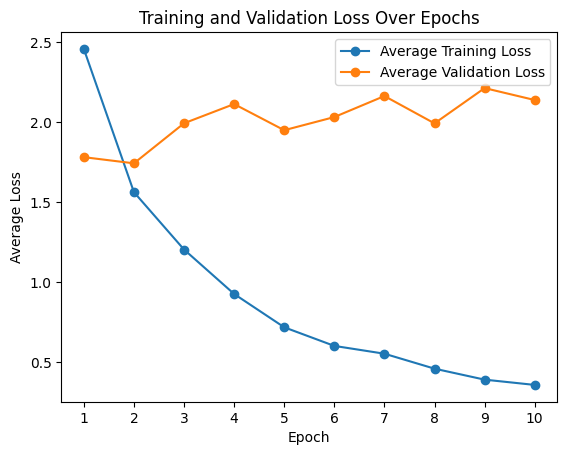

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/549 [00:00<?, ?it/s]

Average test loss: 2.1399
RMSE: 1.4629
MSE: 2.1419
MAE: 1.0911
R²: -0.1822
R: 0.1973
True Skill Score: 0.2502
Accuracy: 0.7211
Precision: 0.3895
Recall: 0.2803
F1 Score: 0.3260


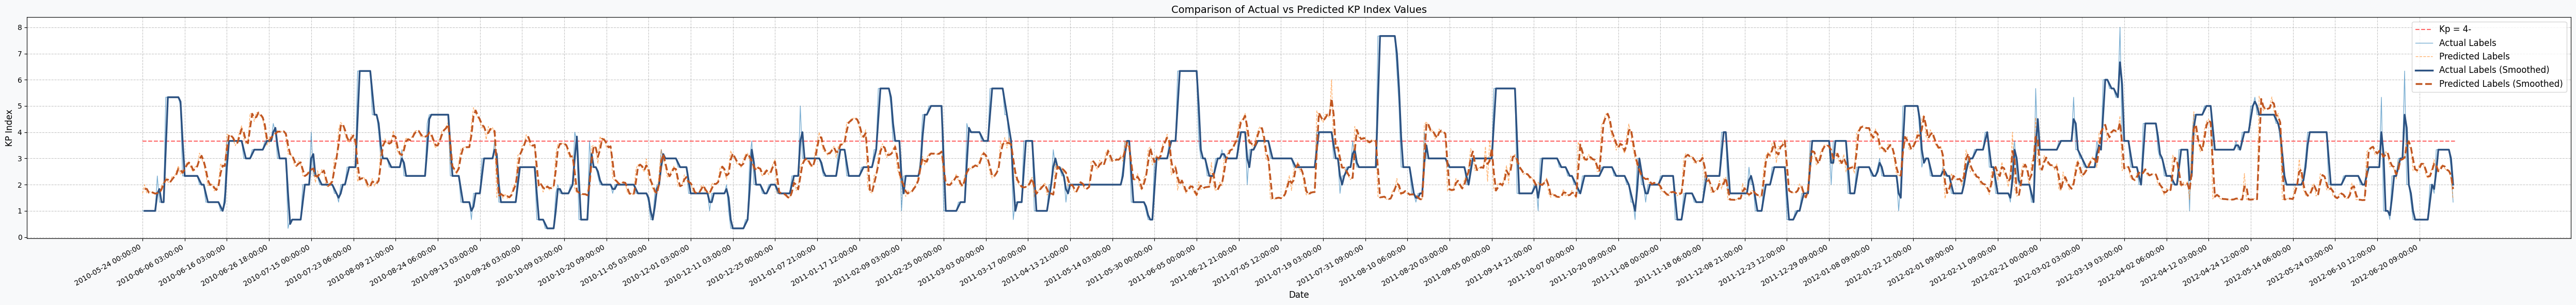

[np.float32(1.6640625), np.float32(2.0), np.float32(1.6796875), np.float32(1.7109375), np.float32(1.734375), np.float32(1.65625), np.float32(1.65625), np.float32(1.703125), np.float32(1.671875), np.float32(1.96875), np.float32(2.078125), np.float32(2.28125), np.float32(2.109375), np.float32(2.0625), np.float32(2.328125), np.float32(2.265625), np.float32(2.5), np.float32(2.71875), np.float32(2.40625), np.float32(2.5), np.float32(2.671875), np.float32(2.828125), np.float32(2.859375), np.float32(2.625), np.float32(2.484375), np.float32(2.6875), np.float32(2.734375), np.float32(3.203125), np.float32(3.0), np.float32(2.796875), np.float32(2.390625), np.float32(1.9609375), np.float32(2.015625), np.float32(2.015625), np.float32(1.7578125), np.float32(1.8359375), np.float32(2.046875), np.float32(2.8125), np.float32(2.640625), np.float32(2.78125), np.float32(3.921875), np.float32(3.890625), np.float32(3.84375), np.float32(3.71875), np.float32(3.484375), np.float32(3.703125), np.float32(4.0), np

Testing Progress:   0%|          | 0/132 [00:00<?, ?it/s]

Average test loss: 5.2964
RMSE: 2.3014
MSE: 5.2964
MAE: 1.7872
R²: -3.8768
R: -0.2309


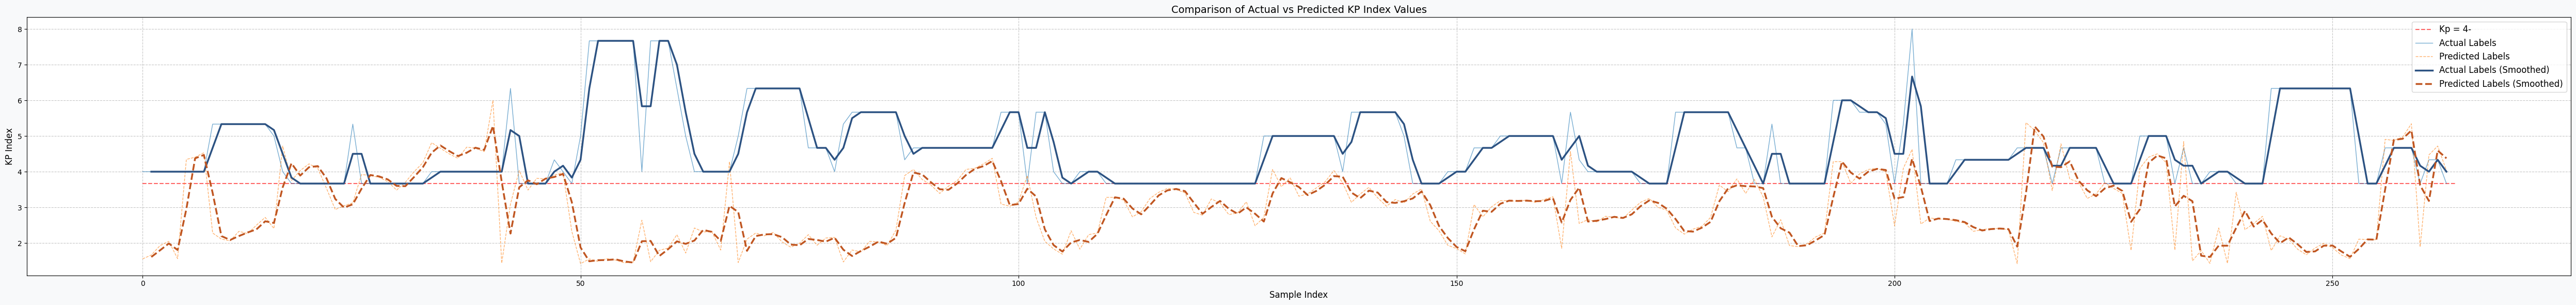

[np.float32(1.5546875), np.float32(1.6640625), np.float32(1.9296875), np.float32(2.046875), np.float32(1.5625), np.float32(4.34375), np.float32(4.40625), np.float32(4.53125), np.float32(2.28125), np.float32(2.109375), np.float32(2.0625), np.float32(2.328125), np.float32(2.265625), np.float32(2.5), np.float32(2.71875), np.float32(2.40625), np.float32(4.71875), np.float32(3.75), np.float32(4.03125), np.float32(4.21875), np.float32(4.09375), np.float32(3.53125), np.float32(2.9375), np.float32(3.046875), np.float32(3.125), np.float32(3.921875), np.float32(3.890625), np.float32(3.84375), np.float32(3.71875), np.float32(3.484375), np.float32(3.703125), np.float32(4.0), np.float32(4.25), np.float32(4.8125), np.float32(4.65625), np.float32(4.5), np.float32(4.375), np.float32(4.6875), np.float32(4.65625), np.float32(4.5625), np.float32(6.0), np.float32(1.4375), np.float32(3.09375), np.float32(4.03125), np.float32(3.484375), np.float32(3.8125), np.float32(3.796875), np.float32(3.90625), np.float

Training Progress: Epoch: 1:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  2.259138526198015


Validation Progress: Epoch: 1:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.2314769514010013


Training Progress: Epoch: 2:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.4050912567141736


Validation Progress: Epoch: 2:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.9427256472805305


Training Progress: Epoch: 3:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.0682384811609995


Validation Progress: Epoch: 3:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.333071023433593


Training Progress: Epoch: 4:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.831502644478843


Validation Progress: Epoch: 4:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.2614763399231244


Training Progress: Epoch: 5:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.6566375326021158


Validation Progress: Epoch: 5:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.0785057284194646


Training Progress: Epoch: 6:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.557394190469745


Validation Progress: Epoch: 6:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.0830823326448806


Training Progress: Epoch: 7:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.4667796876312178


Validation Progress: Epoch: 7:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.358876897341263


Training Progress: Epoch: 8:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.3872209165772495


Validation Progress: Epoch: 8:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.081223627534379


Training Progress: Epoch: 9:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.35215347488723686


Validation Progress: Epoch: 9:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.150945598493671


Training Progress: Epoch: 10:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.3185814464580155


Validation Progress: Epoch: 10:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.1574889193841504


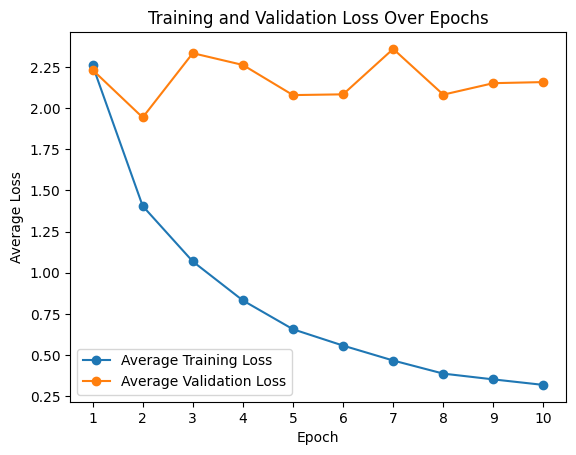

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/549 [00:00<?, ?it/s]

Average test loss: 2.1575
RMSE: 1.4688
MSE: 2.1594
MAE: 1.2317
R²: -0.1010
R: 0.2676
True Skill Score: 0.2507
Accuracy: 0.7238
Precision: 0.3895
Recall: 0.2835
F1 Score: 0.3282


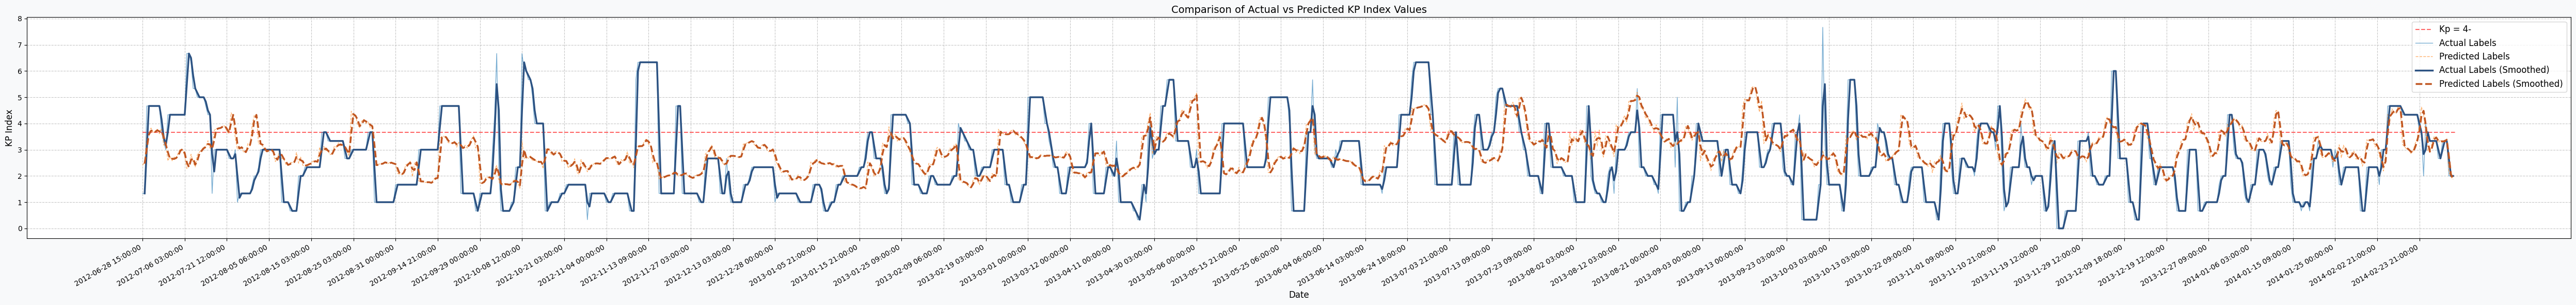

[np.float32(2.40625), np.float32(2.53125), np.float32(3.546875), np.float32(3.609375), np.float32(3.828125), np.float32(3.65625), np.float32(3.703125), np.float32(3.78125), np.float32(3.609375), np.float32(3.8125), np.float32(3.171875), np.float32(3.25), np.float32(2.578125), np.float32(2.734375), np.float32(2.578125), np.float32(2.71875), np.float32(2.65625), np.float32(2.90625), np.float32(3.03125), np.float32(3.0), np.float32(2.75), np.float32(2.28125), np.float32(2.390625), np.float32(2.828125), np.float32(2.515625), np.float32(2.34375), np.float32(2.8125), np.float32(2.90625), np.float32(3.0), np.float32(3.109375), np.float32(3.09375), np.float32(3.34375), np.float32(3.0625), np.float32(3.0), np.float32(3.734375), np.float32(3.8125), np.float32(3.8125), np.float32(3.84375), np.float32(3.90625), np.float32(3.90625), np.float32(3.6875), np.float32(3.625), np.float32(4.40625), np.float32(4.25), np.float32(3.4375), np.float32(3.015625), np.float32(3.078125), np.float32(3.109375), np.f

Testing Progress:   0%|          | 0/131 [00:00<?, ?it/s]

Average test loss: 2.9368
RMSE: 1.7137
MSE: 2.9481
MAE: 1.4447
R²: -3.3566
R: -0.0206


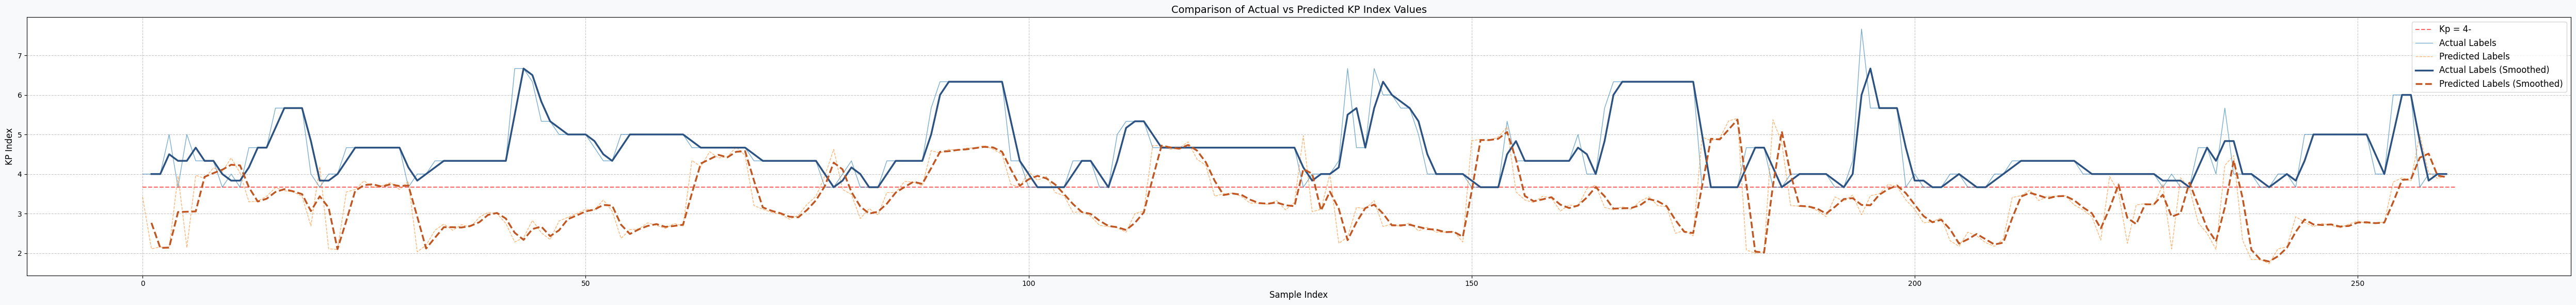

[np.float32(3.421875), np.float32(2.109375), np.float32(2.15625), np.float32(2.125), np.float32(3.953125), np.float32(2.140625), np.float32(3.96875), np.float32(3.890625), np.float32(4.15625), np.float32(4.0625), np.float32(4.40625), np.float32(4.03125), np.float32(3.296875), np.float32(3.3125), np.float32(3.4375), np.float32(3.65625), np.float32(3.578125), np.float32(3.546875), np.float32(3.4375), np.float32(2.6875), np.float32(4.1875), np.float32(2.109375), np.float32(2.09375), np.float32(3.546875), np.float32(3.609375), np.float32(3.828125), np.float32(3.65625), np.float32(3.703125), np.float32(3.78125), np.float32(3.609375), np.float32(3.8125), np.float32(2.03125), np.float32(2.203125), np.float32(2.578125), np.float32(2.734375), np.float32(2.578125), np.float32(2.71875), np.float32(2.65625), np.float32(2.90625), np.float32(3.03125), np.float32(3.0), np.float32(2.75), np.float32(2.28125), np.float32(2.390625), np.float32(2.828125), np.float32(2.515625), np.float32(2.34375), np.floa

Training Progress: Epoch: 1:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  2.2652233425979684


Validation Progress: Epoch: 1:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.8100203982493837


Training Progress: Epoch: 2:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.459399435893091


Validation Progress: Epoch: 2:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.8685331647884562


Training Progress: Epoch: 3:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.1204621948180074


Validation Progress: Epoch: 3:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.9704644286887167


Training Progress: Epoch: 4:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.843121797050501


Validation Progress: Epoch: 4:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.9683160024127018


Training Progress: Epoch: 5:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.685998465421563


Validation Progress: Epoch: 5:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.9549278167870747


Training Progress: Epoch: 6:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.5605476164375431


Validation Progress: Epoch: 6:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.0549850707704276


Training Progress: Epoch: 7:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.4797291288494854


Validation Progress: Epoch: 7:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.4020870574349233


Training Progress: Epoch: 8:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.4204355144707522


Validation Progress: Epoch: 8:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.300750796449242


Training Progress: Epoch: 9:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.3622745105877959


Validation Progress: Epoch: 9:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.879704600600195


Training Progress: Epoch: 10:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.30306510056231706


Validation Progress: Epoch: 10:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.384177126562501


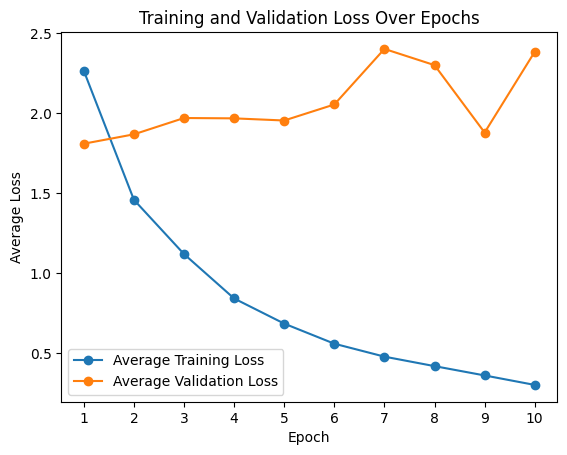

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/549 [00:00<?, ?it/s]

Average test loss: 2.3842
RMSE: 1.5441
MSE: 2.3849
MAE: 1.1866
R²: -0.2641
R: 0.2426
True Skill Score: 0.5453
Accuracy: 0.6682
Precision: 0.6275
Recall: 0.2382
F1 Score: 0.3453


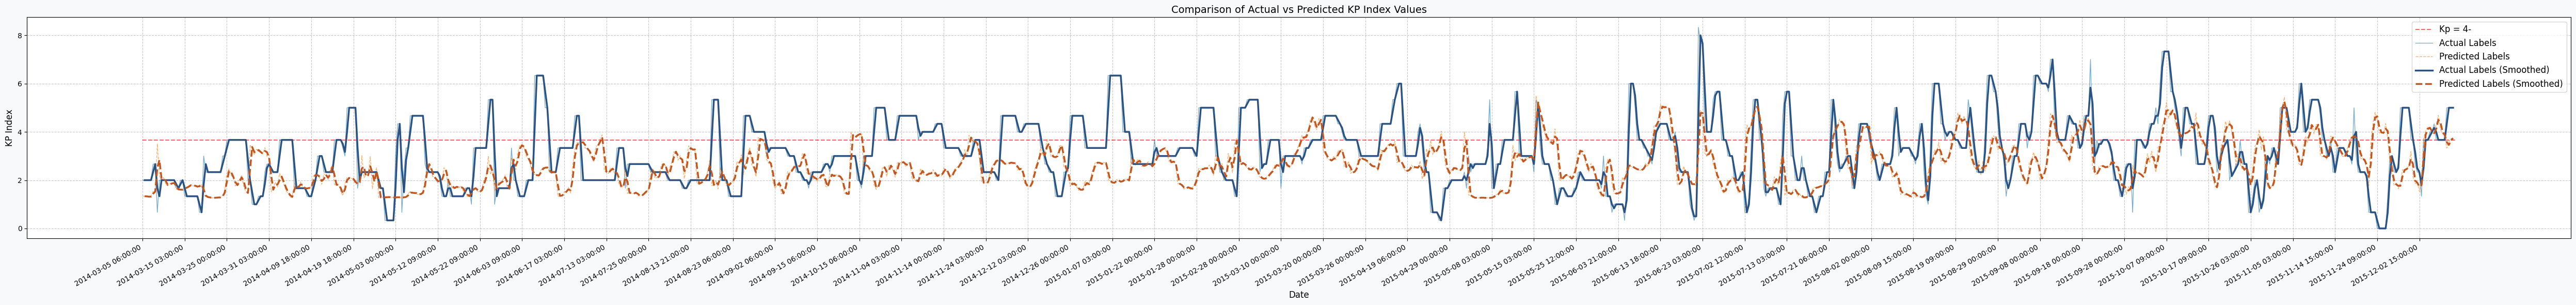

[np.float32(1.34375), np.float32(1.328125), np.float32(1.328125), np.float32(1.3046875), np.float32(1.3359375), np.float32(1.53125), np.float32(1.53125), np.float32(3.5), np.float32(2.171875), np.float32(1.9609375), np.float32(2.125), np.float32(1.8203125), np.float32(1.7734375), np.float32(1.859375), np.float32(1.875), np.float32(1.890625), np.float32(1.6171875), np.float32(1.6171875), np.float32(1.6015625), np.float32(1.609375), np.float32(1.703125), np.float32(1.6796875), np.float32(1.7890625), np.float32(1.796875), np.float32(1.7578125), np.float32(1.78125), np.float32(1.6953125), np.float32(1.796875), np.float32(1.8203125), np.float32(1.4140625), np.float32(1.3046875), np.float32(1.296875), np.float32(1.2734375), np.float32(1.265625), np.float32(1.2734375), np.float32(1.2734375), np.float32(1.2890625), np.float32(1.28125), np.float32(1.375), np.float32(1.59375), np.float32(2.28125), np.float32(2.46875), np.float32(2.203125), np.float32(2.09375), np.float32(1.7578125), np.float32(1

Testing Progress:   0%|          | 0/202 [00:00<?, ?it/s]

Average test loss: 4.3537
RMSE: 2.0865
MSE: 4.3606
MAE: 1.7784
R²: -4.4716
R: 0.1068


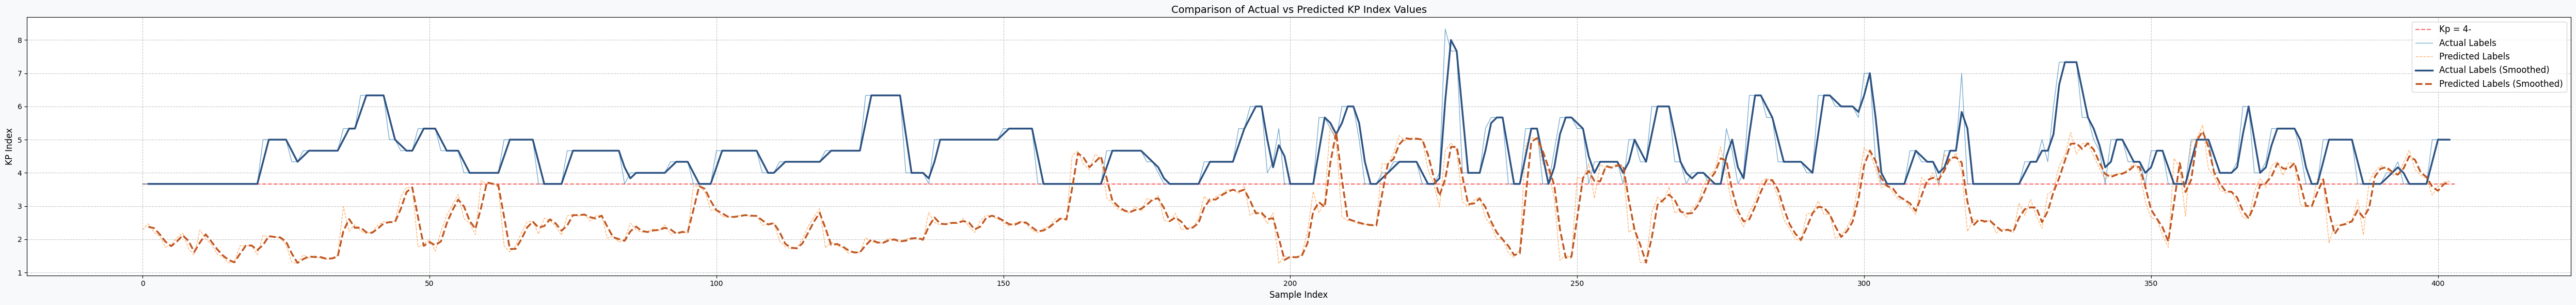

[np.float32(2.28125), np.float32(2.46875), np.float32(2.203125), np.float32(2.09375), np.float32(1.7578125), np.float32(1.828125), np.float32(2.046875), np.float32(2.1875), np.float32(1.71875), np.float32(1.5234375), np.float32(2.28125), np.float32(2.015625), np.float32(1.84375), np.float32(1.5546875), np.float32(1.46875), np.float32(1.2890625), np.float32(1.3203125), np.float32(1.8125), np.float32(1.8046875), np.float32(1.8203125), np.float32(1.53125), np.float32(2.125), np.float32(2.0625), np.float32(2.078125), np.float32(2.03125), np.float32(1.8359375), np.float32(1.3046875), np.float32(1.2734375), np.float32(1.53125), np.float32(1.4296875), np.float32(1.5), np.float32(1.4296875), np.float32(1.3984375), np.float32(1.4453125), np.float32(1.5078125), np.float32(2.984375), np.float32(2.234375), np.float32(2.453125), np.float32(2.25), np.float32(2.171875), np.float32(2.21875), np.float32(2.421875), np.float32(2.53125), np.float32(2.5), np.float32(2.546875), np.float32(3.28125), np.float

Training Progress: Epoch: 1:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  2.3689138491087487


Validation Progress: Epoch: 1:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.7801805204311716


Training Progress: Epoch: 2:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.6424875297423733


Validation Progress: Epoch: 2:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.5047807289285036


Training Progress: Epoch: 3:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.29251934984168


Validation Progress: Epoch: 3:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.4944136180241256


Training Progress: Epoch: 4:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.9558323148915656


Validation Progress: Epoch: 4:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.6504528468087967


Training Progress: Epoch: 5:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.7494632079453496


Validation Progress: Epoch: 5:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.541229732267606


Training Progress: Epoch: 6:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.6131161641233962


Validation Progress: Epoch: 6:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.6373135038445414


Training Progress: Epoch: 7:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.5252006594612871


Validation Progress: Epoch: 7:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.506764995661638


Training Progress: Epoch: 8:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.425707908374064


Validation Progress: Epoch: 8:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.565710868381722


Training Progress: Epoch: 9:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.37208257061363026


Validation Progress: Epoch: 9:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.5767623978108847


Training Progress: Epoch: 10:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.32165838530118124


Validation Progress: Epoch: 10:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.7815541019463887


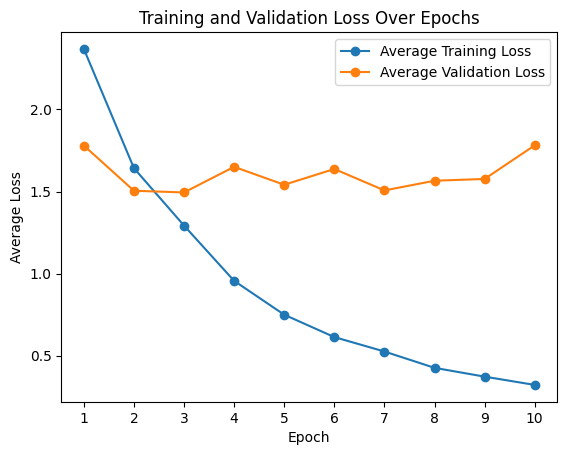

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/549 [00:00<?, ?it/s]

Average test loss: 1.7816
RMSE: 1.3347
MSE: 1.7826
MAE: 1.0920
R²: 0.0283
R: 0.4641
True Skill Score: 0.2865
Accuracy: 0.6755
Precision: 0.5922
Recall: 0.6480
F1 Score: 0.6188


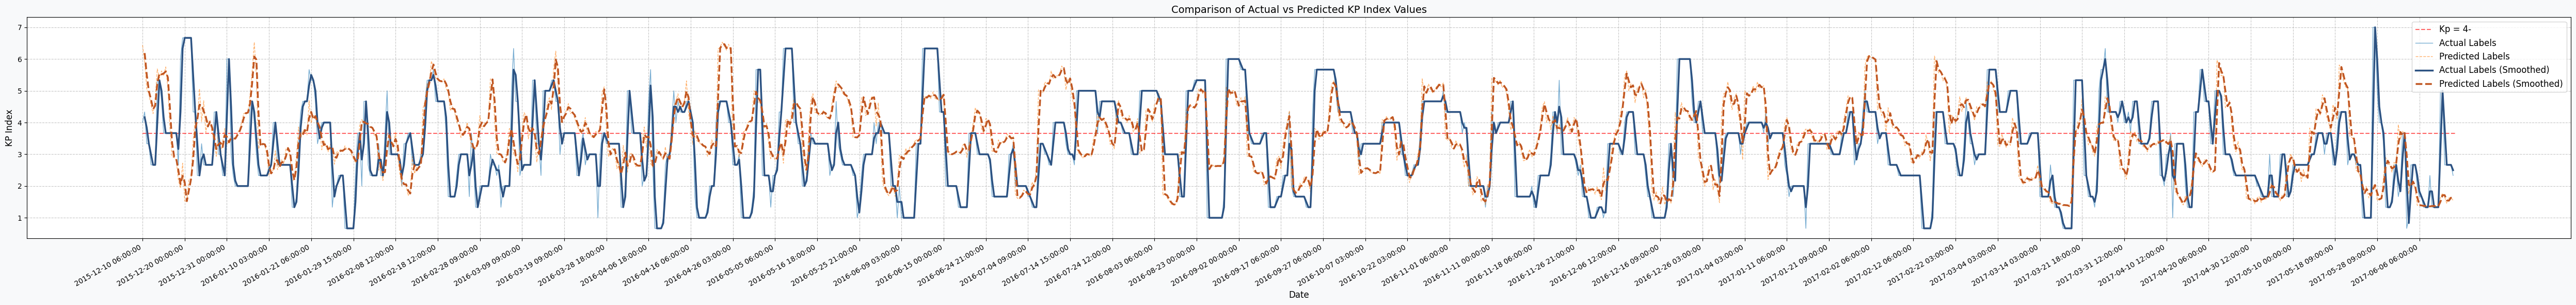

[np.float32(6.4375), np.float32(5.9375), np.float32(5.0625), np.float32(4.90625), np.float32(4.5625), np.float32(4.28125), np.float32(4.78125), np.float32(5.6875), np.float32(5.40625), np.float32(5.625), np.float32(5.46875), np.float32(5.75), np.float32(5.09375), np.float32(3.8125), np.float32(2.921875), np.float32(2.90625), np.float32(2.796875), np.float32(2.1875), np.float32(1.9296875), np.float32(2.71875), np.float32(1.53125), np.float32(1.515625), np.float32(2.21875), np.float32(2.21875), np.float32(3.4375), np.float32(4.15625), np.float32(4.0625), np.float32(5.0625), np.float32(4.03125), np.float32(4.6875), np.float32(3.6875), np.float32(4.0625), np.float32(4.0), np.float32(3.6875), np.float32(3.390625), np.float32(2.9375), np.float32(3.6875), np.float32(3.046875), np.float32(3.40625), np.float32(3.8125), np.float32(3.296875), np.float32(3.453125), np.float32(3.5625), np.float32(3.4375), np.float32(3.546875), np.float32(3.65625), np.float32(3.78125), np.float32(4.0), np.float32(4.

Testing Progress:   0%|          | 0/223 [00:00<?, ?it/s]

Average test loss: 1.9067
RMSE: 1.3808
MSE: 1.9067
MAE: 1.1094
R²: -2.0033
R: 0.0810


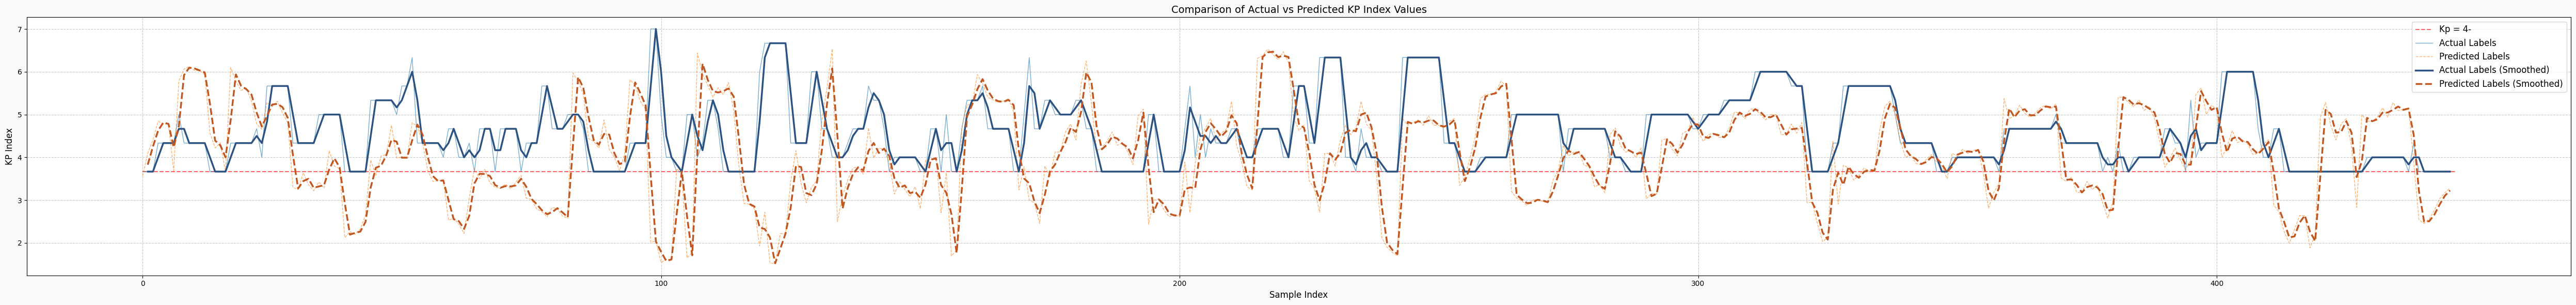

[np.float32(3.5625), np.float32(4.09375), np.float32(4.40625), np.float32(4.84375), np.float32(4.78125), np.float32(4.78125), np.float32(3.6875), np.float32(5.78125), np.float32(6.0625), np.float32(6.125), np.float32(6.03125), np.float32(6.03125), np.float32(5.9375), np.float32(4.5625), np.float32(4.21875), np.float32(4.34375), np.float32(3.65625), np.float32(6.09375), np.float32(5.78125), np.float32(5.5625), np.float32(5.625), np.float32(5.3125), np.float32(4.78125), np.float32(4.65625), np.float32(5.28125), np.float32(5.1875), np.float32(5.3125), np.float32(5.03125), np.float32(4.8125), np.float32(3.296875), np.float32(3.25), np.float32(3.640625), np.float32(3.359375), np.float32(3.21875), np.float32(3.421875), np.float32(3.28125), np.float32(4.15625), np.float32(3.796875), np.float32(3.734375), np.float32(2.125), np.float32(2.265625), np.float32(2.203125), np.float32(2.328125), np.float32(2.65625), np.float32(3.9375), np.float32(3.578125), np.float32(4.03125), np.float32(4.0625), np

Training Progress: Epoch: 1:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  2.414307075032222


Validation Progress: Epoch: 1:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.491785847363532


Training Progress: Epoch: 2:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  1.634309544627273


Validation Progress: Epoch: 2:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.3723731603921094


Training Progress: Epoch: 3:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  1.309162898964225


Validation Progress: Epoch: 3:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.3575752646481323


Training Progress: Epoch: 4:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  1.0898064282923765


Validation Progress: Epoch: 4:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.3716007992354307


Training Progress: Epoch: 5:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.830667688813944


Validation Progress: Epoch: 5:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.5630567281109027


Training Progress: Epoch: 6:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.7117691484941652


Validation Progress: Epoch: 6:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.5416068216654557


Training Progress: Epoch: 7:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.5751190005243206


Validation Progress: Epoch: 7:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.561114944779666


Training Progress: Epoch: 8:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.4970234146314866


Validation Progress: Epoch: 8:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.4269175098212012


Training Progress: Epoch: 9:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.42314039155692673


Validation Progress: Epoch: 9:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.462820263267508


Training Progress: Epoch: 10:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.37117713283085424


Validation Progress: Epoch: 10:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.600719208001921


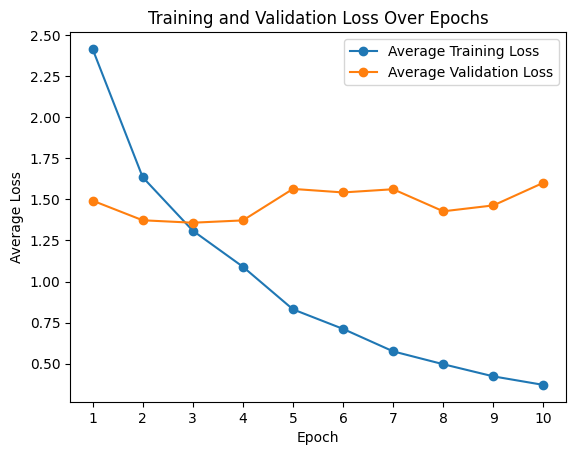

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/550 [00:00<?, ?it/s]

Average test loss: 1.6007
RMSE: 1.2652
MSE: 1.6012
MAE: 1.0207
R²: 0.0917
R: 0.4174
True Skill Score: 0.4335
Accuracy: 0.7288
Precision: 0.5660
Recall: 0.4043
F1 Score: 0.4716


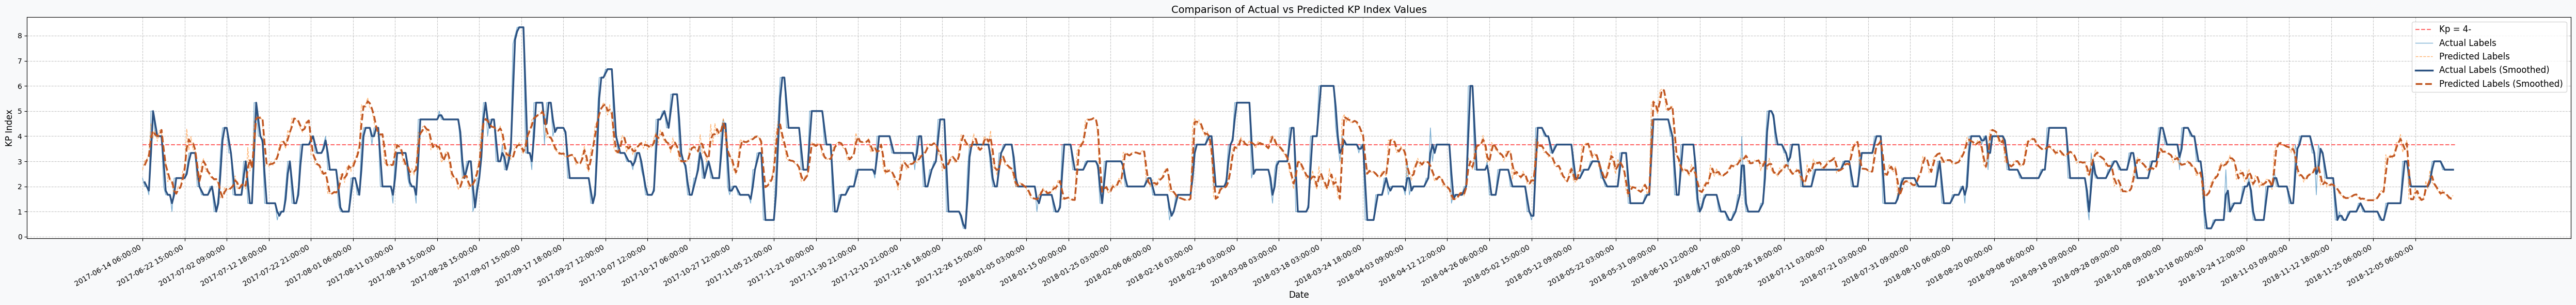

[np.float32(2.65625), np.float32(3.015625), np.float32(3.0625), np.float32(3.34375), np.float32(4.5), np.float32(3.921875), np.float32(4.21875), np.float32(3.796875), np.float32(4.21875), np.float32(4.28125), np.float32(2.765625), np.float32(2.953125), np.float32(2.1875), np.float32(2.359375), np.float32(2.0625), np.float32(1.6640625), np.float32(1.7578125), np.float32(2.015625), np.float32(1.9140625), np.float32(2.578125), np.float32(2.78125), np.float32(4.28125), np.float32(3.46875), np.float32(3.984375), np.float32(3.453125), np.float32(3.46875), np.float32(2.234375), np.float32(2.1875), np.float32(2.890625), np.float32(3.109375), np.float32(2.609375), np.float32(2.59375), np.float32(2.40625), np.float32(2.328125), np.float32(2.25), np.float32(2.328125), np.float32(2.046875), np.float32(1.546875), np.float32(1.5859375), np.float32(1.96875), np.float32(1.84375), np.float32(1.8984375), np.float32(1.9765625), np.float32(2.0625), np.float32(2.421875), np.float32(1.890625), np.float32(1.

Testing Progress:   0%|          | 0/165 [00:00<?, ?it/s]

Average test loss: 2.1488
RMSE: 1.4659
MSE: 2.1532
MAE: 1.1638
R²: -1.7863
R: 0.1988


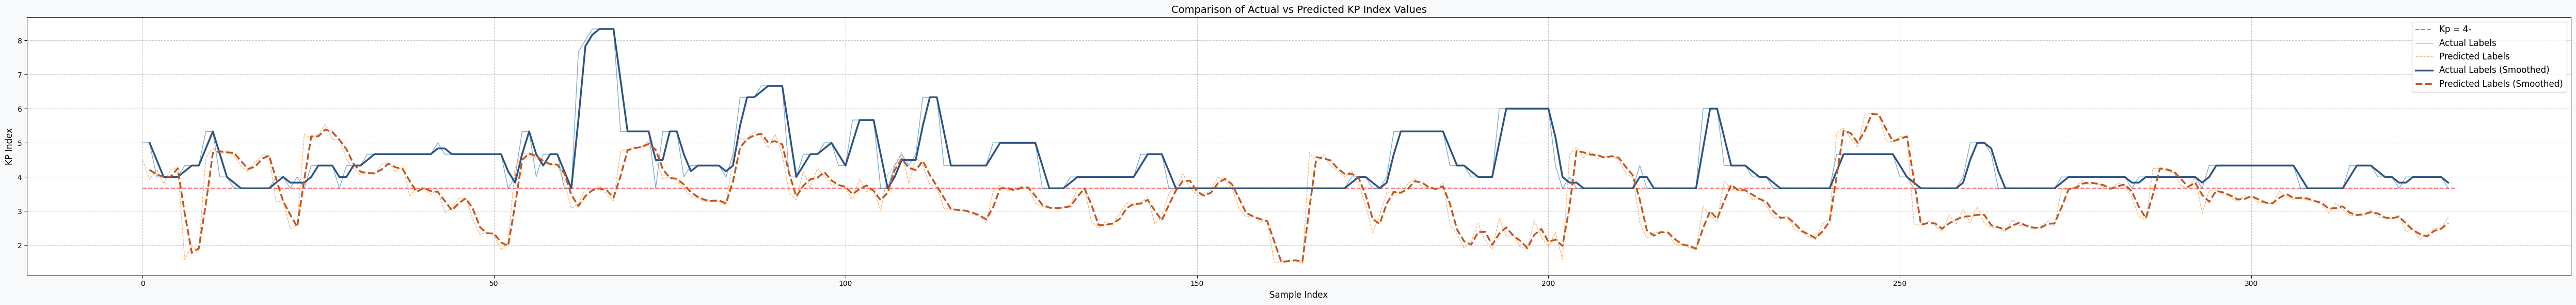

[np.float32(4.5), np.float32(3.921875), np.float32(4.21875), np.float32(3.796875), np.float32(4.21875), np.float32(4.28125), np.float32(1.5859375), np.float32(1.96875), np.float32(1.84375), np.float32(4.5625), np.float32(4.84375), np.float32(4.65625), np.float32(4.78125), np.float32(4.625), np.float32(4.3125), np.float32(4.15625), np.float32(4.4375), np.float32(4.625), np.float32(4.625), np.float32(3.265625), np.float32(3.3125), np.float32(2.484375), np.float32(2.59375), np.float32(5.25), np.float32(5.125), np.float32(5.25), np.float32(5.53125), np.float32(5.09375), np.float32(5.09375), np.float32(4.53125), np.float32(4.25), np.float32(4.0625), np.float32(4.15625), np.float32(4.0625), np.float32(4.375), np.float32(4.40625), np.float32(4.15625), np.float32(4.3125), np.float32(3.453125), np.float32(3.671875), np.float32(3.6875), np.float32(3.484375), np.float32(3.640625), np.float32(2.953125), np.float32(3.09375), np.float32(3.375), np.float32(3.375), np.float32(2.75), np.float32(2.3125)

In [ ]:
torch.set_float32_matmul_precision('medium')
fabric = Fabric(accelerator='cuda', devices=1, precision="bf16-mixed")
fabric.launch(train_model)

In [ ]:
# prompt: disconnect runtime
import time
time.sleep(5 * 60)
from google.colab import runtime
runtime.unassign()
